# Проект: Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

План работы:
 - Просмотреть и изучить общую информацию о данных;
 - Обработать по отдлеьности каждый датасет, некоторые данные видоизменить для улучшения возможности обучения  модели;
 - Объединить данные и рассмотреть распределение каждого признака. Изучить корреляционную картину;
 - Подготовить даннные к обучению;
 - Обучить несколько алгоритмов машинного обучения и выбрать лучший на кросс-валидации/тренировочной выборке;
 - Проверим точность лучшей модели на метрике MAE, которая должна быть <= 6.8;
 - Интерпретировать результаты модели на тестовой выборке;
 - Сделать итоговый вывод и дать рекомендации;

In [1]:
! pip install shap

In [2]:
! pip install phik

In [3]:
! pip install missingno

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
import phik
import time
import shap
from phik import resources, report
import seaborn as sns
import missingno as msn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor 
from sklearn.dummy import DummyRegressor
from sklearn import tree

In [5]:
warnings.filterwarnings('ignore')

In [6]:
try:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('data_arc_new.csv')
    data_bulk = pd.read_csv('data_bulk_new.csv')
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_wire = pd.read_csv('data_wire_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv')

## Изучение общей информации о данных

In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [8]:
data_arc.head()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

**Датасет не имеет пропущенных значений. Имеем два столбца с временем начала и конца нагрева, которые в дальнейшем преобразуем в один - `Длительность нагрева`. Это позволит уменьшить количество признаков, а смысл останется такой же.**

In [9]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

**Датасет о добавочных материалах содержит достаточно много пропусков относительно общего его размера. Это можно объяснить отсутствием той или иной добавки в партию.**

In [11]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [12]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

**Датасет о времени добавки материала содержит аналогичный пропуски, которые можно объяснить тем же. Можно сразу заметить, что порядок наполнения продукта идет разными схемами. Компоненты вносятся в разном порядке.**

In [13]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [14]:
data_gas.head()

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

**Информация о количестве газа, которым продувался продукт тоже не имеет пропусков.**

In [15]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [16]:
data_temp.head()

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

**Информация этой таблицы содержит target значение - Температура, а также момент времени её замера. История значений температуры может быть определенно связана с материалами, которые были добавлены в той или иной момент.**

In [17]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [18]:
data_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

**Наличие пропусков в данной таблице также можно объяснить тем, что для достижения нужного качества продукта требуется определённый(-ые) тип(-ы) проволочных материалов.**

In [19]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [20]:
data_wire_time.head()

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

**Данные имеют информацию о моменте времени добавки проволочного материала, наличие пропусков объясняется тем же фактом.**

**`Вывод по первому шагу`: Просмотрены первые строки датасетов и общая информация. Заметны часто встречающиеся пропуски, описаны предположения их появлений.**

## Исследовательский анализ и предобработка данных

In [21]:
def numeric_features(data, features):
    plt.boxplot(data[features])
    plt.ylabel('Значения столбца ' + str(features))
    plt.title('Диаграмма ящика с усами для признака ' + str(features))
    plt.show()
def frequency_features(data, features, bins=10):
    plt.hist(data[features], bins=bins)
    plt.ylabel('Количество объектов в столбце ' + str(features))
    plt.xlabel('Значения столбца ' + str(features))
    plt.title('Гистограмма для признака ' + str(features))
    plt.show()

### data_arc

In [22]:
data_arc.head()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

**Заменим столбцы с информацией о начале и конце нагрева на промежуток нагрева.**

In [23]:
data_arc['Длительность нагрева'] = (pd.to_datetime(data_arc['Конец нагрева дугой']) - 
                                    pd.to_datetime(data_arc['Начало нагрева дугой'])).dt.total_seconds()

In [24]:
data_arc = data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)
columns = data_arc.columns
columns

Index(['key', 'Активная мощность', 'Реактивная мощность',
       'Длительность нагрева'],
      dtype='object')

In [25]:
data_arc.head()

key  Активная мощность  Реактивная мощность  Длительность нагрева
0    1           0.305130             0.211253                 228.0
1    1           0.765658             0.477438                 185.0
2    1           0.580313             0.430460                 172.0
3    1           0.518496             0.379979                 365.0
4    1           0.867133             0.643691                 148.0

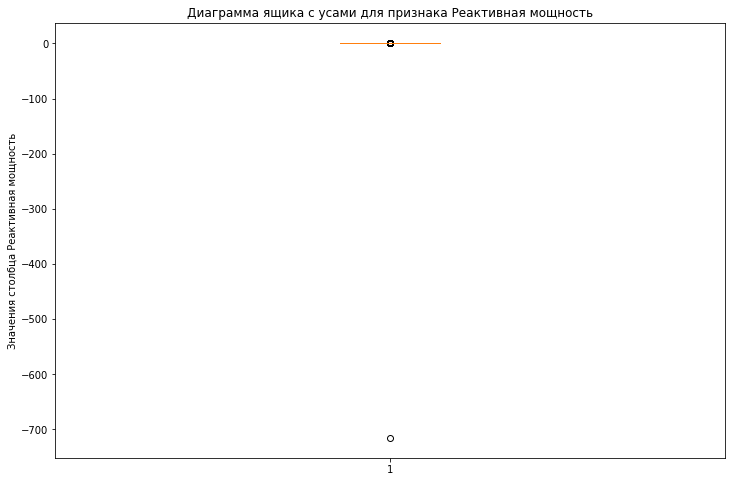

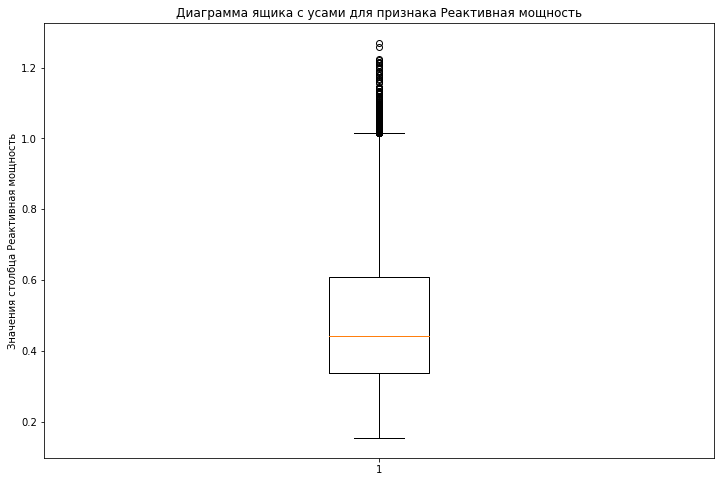

In [26]:
numeric_features(data_arc, columns[2])
data_arc = data_arc[data_arc[columns[2]] > 0]
numeric_features(data_arc, columns[2])

**Наблюдаем значение с отрицательной мощностью, чего быть не может, уберем из данных это аномальное значение и тут же отрисуем `boxplot` с измененными данными. Наблюдаем достаточно хорошее распределение столбца, хоть и есть значения, которые выходят за усы графика, но не очень критично от основной массы данных. Среднее значение находится около 0.45.**

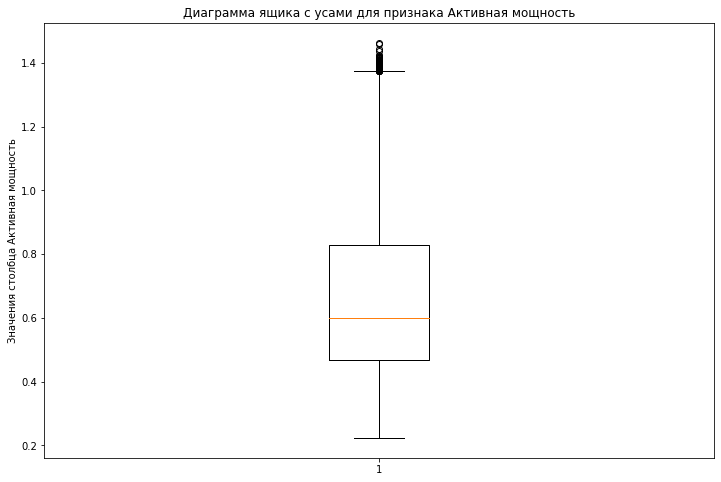

In [27]:
numeric_features(data_arc, columns[1])

**Активная мощность уже без аномалий, также `boxplot` показал наличие выбросов, но они соизмеримы с основными данными. Среднее значение наблюдается около 0.6.**

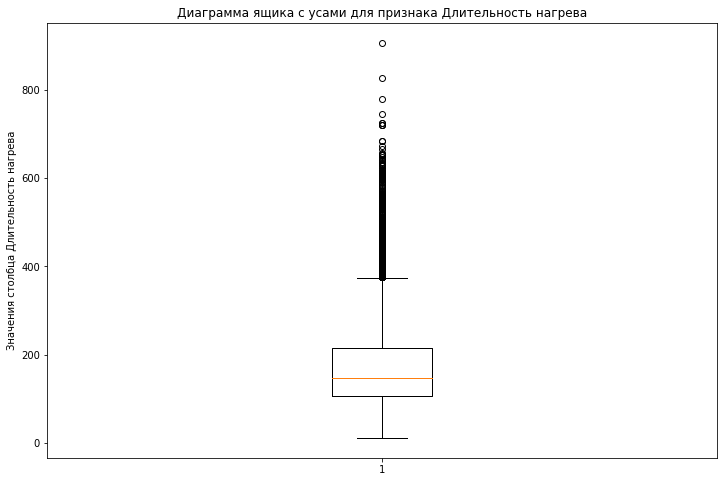

In [28]:
numeric_features(data_arc, columns[3])

**Длительность нагрева уже показывает другой результат. Выбросов уже намного больше, но это имеет место быть, технологический процесс непредсказуем и в данном случае нагревание требовало много времени в некоторых попытках.**

In [29]:
data_arc.head()

key  Активная мощность  Реактивная мощность  Длительность нагрева
0    1           0.305130             0.211253                 228.0
1    1           0.765658             0.477438                 185.0
2    1           0.580313             0.430460                 172.0
3    1           0.518496             0.379979                 365.0
4    1           0.867133             0.643691                 148.0

**Для корретного объединения признаков в дальнейшем этот датасет нужно агрегировать, чтобы была единая информация о партии. длительность возьмем по среднему, а мощности по максмальному значению.**

In [30]:
# Вычисляем минимальное и максимальное время для каждой партии
data_arc_agg = data_arc.groupby('key').agg(
    act_power=('Активная мощность' ,'max'),
    re_power=('Реактивная мощность', 'max'),
    time_heating=('Длительность нагрева', 'mean')
).reset_index()

In [31]:
data_arc_agg

key  act_power  re_power  time_heating
0        1   0.867133  0.643691        219.60
1        2   0.786322  0.542517        202.75
2        3   1.222963  0.863676        131.00
3        4   0.887855  0.654661        185.25
4        5   0.892957  0.660807        217.25
...    ...        ...       ...           ...
3209  3237   1.090839  0.878488        181.80
3210  3238   0.623378  0.436618        182.00
3211  3239   0.894547  0.613122        152.00
3212  3240   1.202454  0.846936        167.80
3213  3241   1.039726  0.769302        131.80

[3214 rows x 4 columns]

### data_bulk

In [32]:
data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

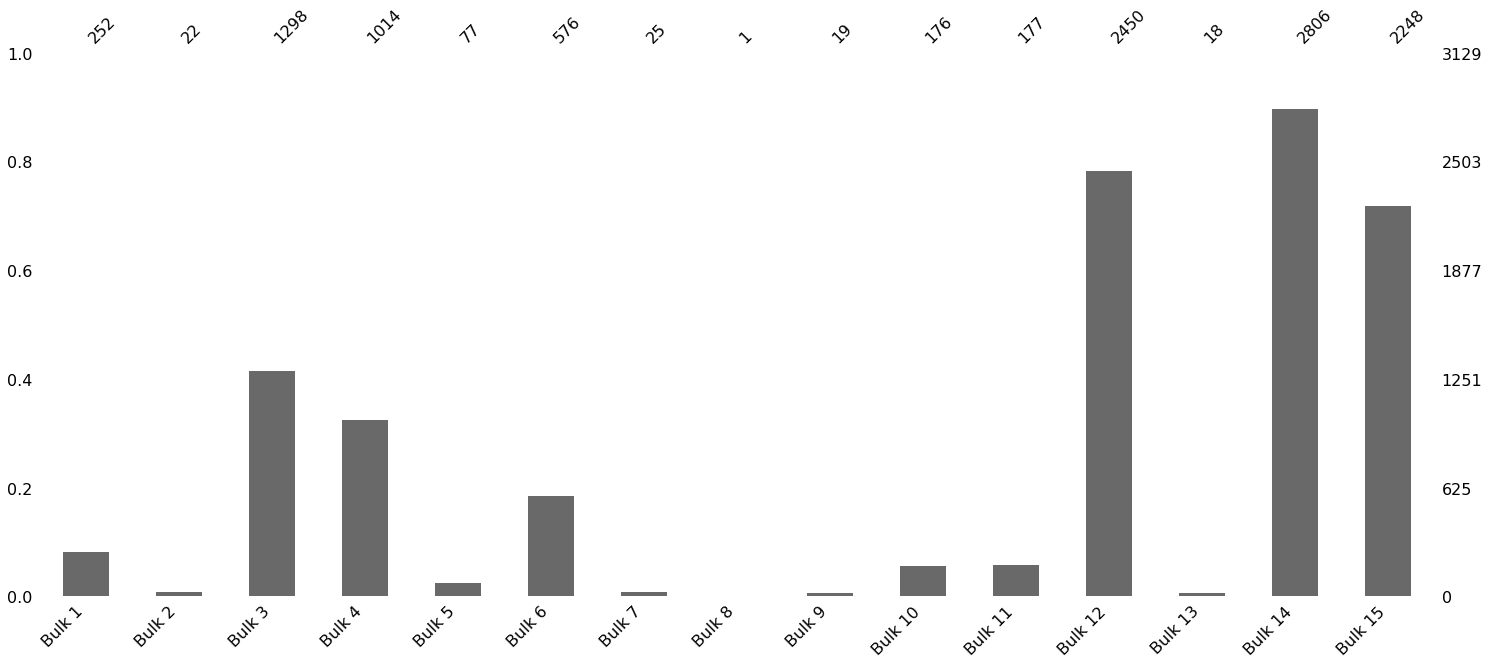

In [33]:
msn.bar(data_bulk.drop('key', axis=1))
plt.show()

**По полученной диаграмме можно сказать, что чаще всего использовали элемент 14 в виде добавки, наименее популярный элемент 8.**

**Чтобы сделать датасет более информативным и более понятным для моделей, а также удобным для объединения, из 15 признаков сделаем 2. Первый признак будет отражать общий объем добавок, а второй количество видов этих добавок**

In [34]:
data_bulk['bulk_sum'] = data_bulk.drop('key', axis=1).sum(axis=1)
data_bulk['bulk_count'] = data_bulk.drop(['key', 'bulk_sum'], axis=1).notnull().sum(axis=1)

In [35]:
data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  bulk_sum  \
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0     553.0   
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0     582.0   
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0     544.0   
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0     595.0   
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0     584.0   

   bulk_count  
0           4  
1           4  
2           4  
3           4  
4           4

**Преобразования проведены корректно, теперь исследуем полученные признаки.**

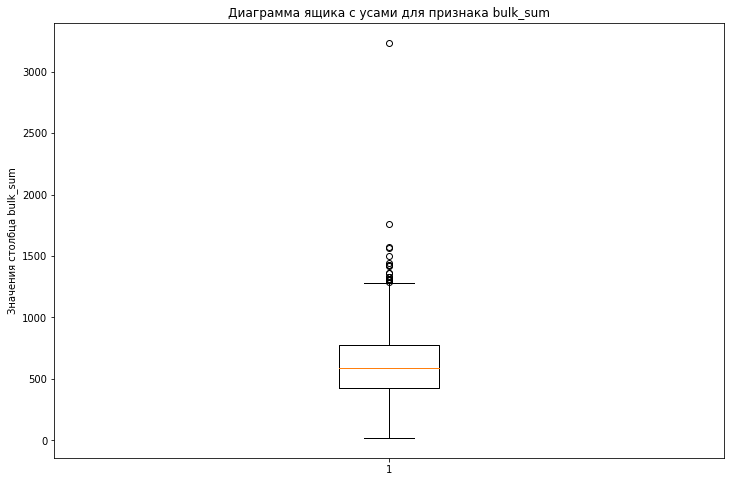

In [36]:
numeric_features(data_bulk, 'bulk_sum')

**Из полученного ящика с усами видим одно сильно выбивающееся значение, но считать его аномальным также не стоит, размер добавок может быть таким(около 3000). Среднее значение суммарных добавок около 600 единиц.**

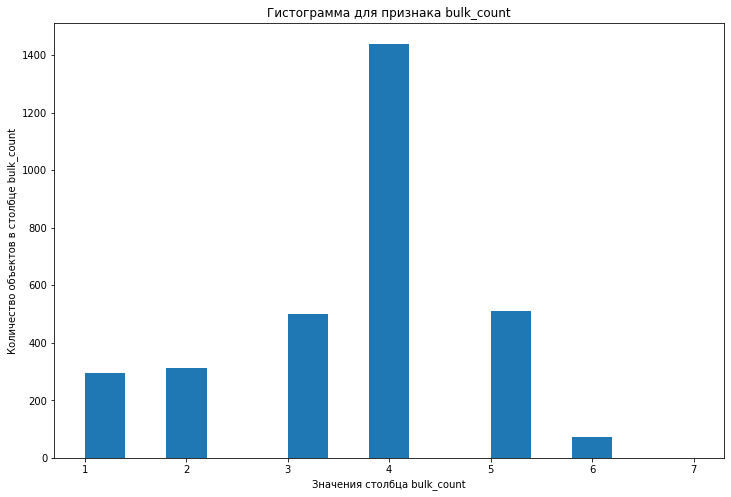

In [37]:
frequency_features(data_bulk, 'bulk_count', bins=15)

**Получаем, что чаще всего добавляют по 4 вида материалов в продукт, а реже всего по 6.**

### data_bulk_time

In [38]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

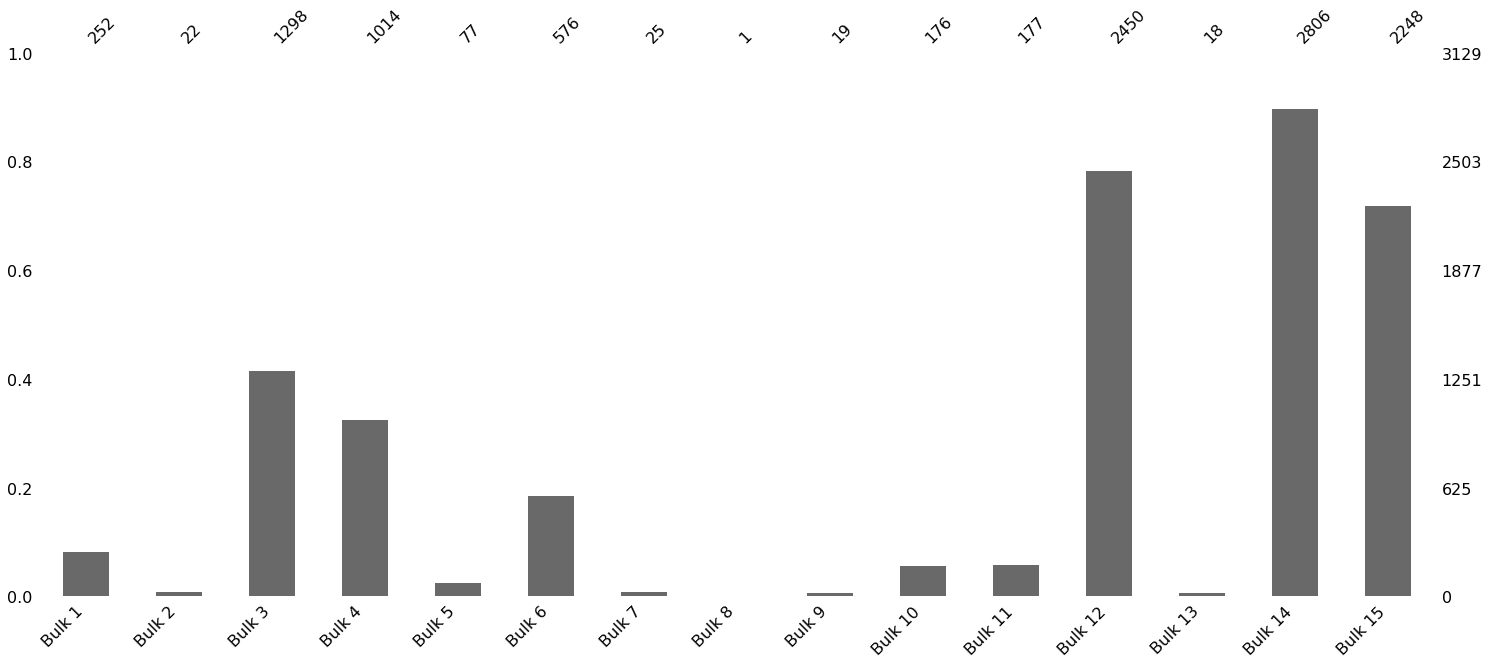

In [39]:
msn.bar(data_bulk_time.drop('key', axis=1))
plt.show()

**Пропуски имеют такую же структуру, что и в data_bulk, это хорошо, что нету никаких различий и данные записываются корректно для каждого вида bulk.**

In [40]:
# Изменим тип столбцов с датами
for col in data_bulk_time.drop('key', axis=1).columns:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col])

In [41]:
#Проверим корректность
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [42]:
#Создадим признак - промежуток времени между 1 и последним добавлением bulk
data_bulk_time['interval_bulk'] = (data_bulk_time.drop('key', axis=1).
                                apply(lambda row: (row.max() - row.min()).total_seconds(), axis=1))

In [43]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3              Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:36:50    NaT    NaT    NaT    NaT   
2    3    NaT    NaT    NaT 2019-05-03 12:32:39    NaT    NaT    NaT    NaT   
3    4    NaT    NaT    NaT 2019-05-03 12:43:22    NaT    NaT    NaT    NaT   
4    5    NaT    NaT    NaT 2019-05-03 13:30:47    NaT    NaT    NaT    NaT   

  Bulk 9 Bulk 10 Bulk 11             Bulk 12 Bulk 13             Bulk 14  \
0    NaT     NaT     NaT 2019-05-03 11:24:31     NaT 2019-05-03 11:14:50   
1    NaT     NaT     NaT 2019-05-03 11:53:30     NaT 2019-05-03 11:48:37   
2    NaT     NaT     NaT 2019-05-03 12:27:13     NaT 2019-05-03 12:21:01   
3    NaT     NaT     NaT 2019-05-03 12:58:00     NaT 2019-05-03 12:51:11   
4    NaT     NaT     NaT 2019-05-03 13:30:47     NaT 2019-05-03 13:34:12   

              Bulk 15  interval_bulk  
0 2019-05-03 11:10:43         1085.0  
1 2019-05-03 11:44:39         1000.0  
2 2019-05-03 12:16:16          983.0  
3 2019-05-03 12:46:36          878.0  
4 2019-05-03 13:30:47          205.0

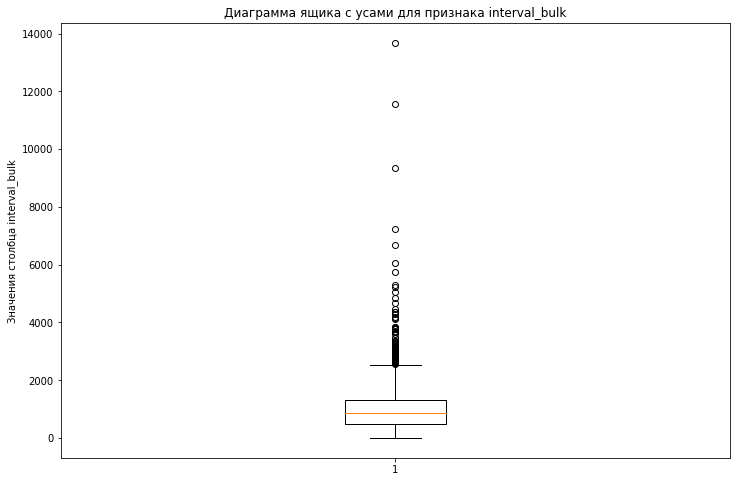

In [44]:
numeric_features(data_bulk_time, 'interval_bulk')

**Исследуя новый признак, можно сказать, что в среднем промежуток добавления  всех необходимых bulk составляет 1000 секунд - около 16-17 минут, но есть и случаи когда нужно около 3-4 часов.**

### data_gas

In [45]:
data_gas.head()

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

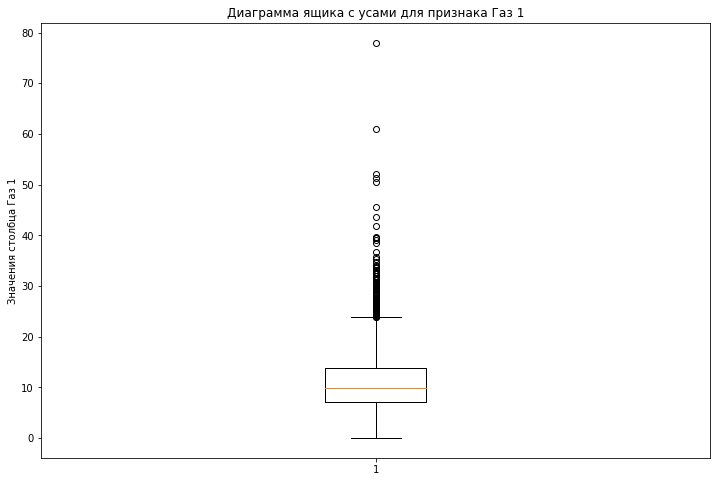

In [46]:
numeric_features(data_gas, 'Газ 1')

**В датасете с объемом газа, которым продувают продукт видим также много выбивающихся значений. Среднее значение около 10 единиц.**

### data_temp

In [47]:
data_temp.head(10)

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0
5    1  2019-05-03 11:30:38       1613.0
6    2  2019-05-03 11:34:04       1581.0
7    2  2019-05-03 11:38:40       1577.0
8    2  2019-05-03 11:46:09       1589.0
9    2  2019-05-03 11:49:38       1604.0

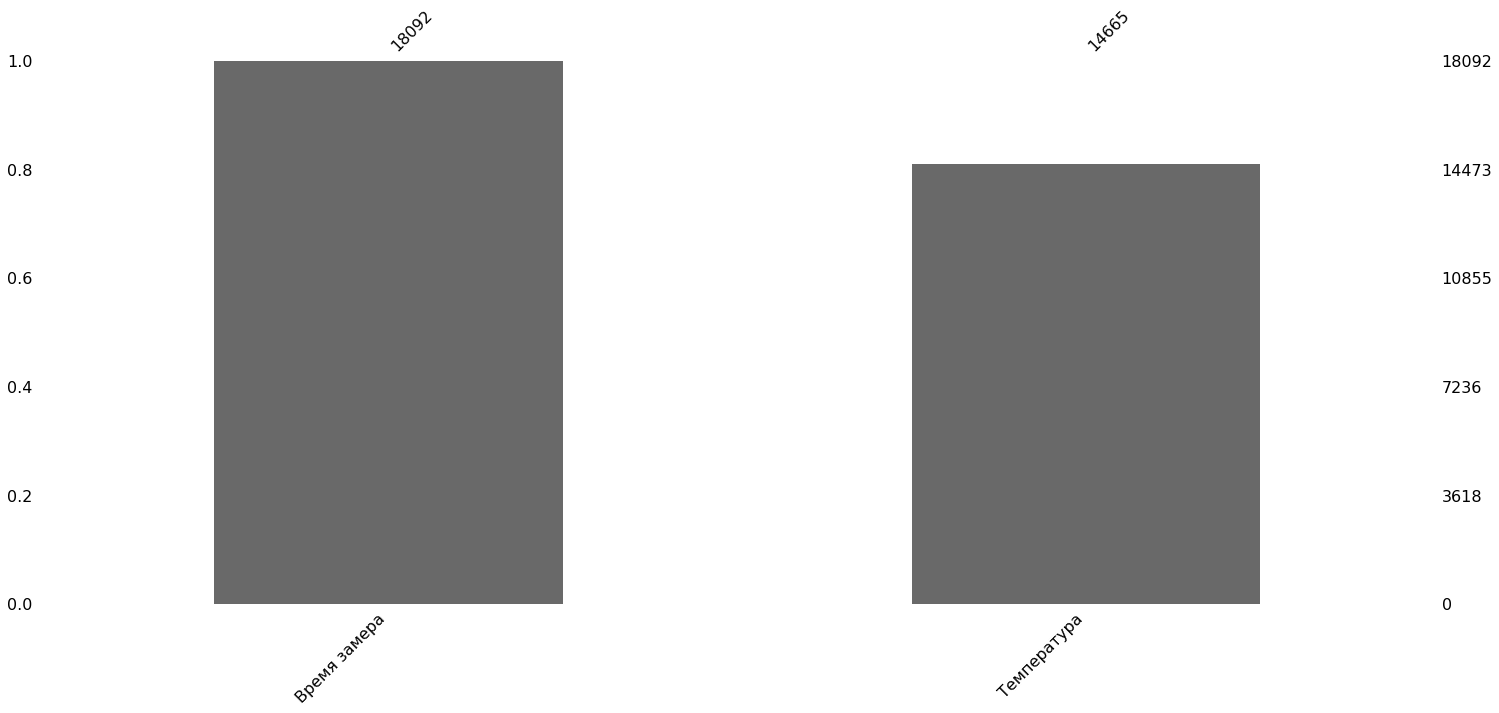

In [48]:
msn.bar(data_temp.drop('key', axis=1))
plt.show()

**Видим наличие пропусков в столбце с температурой, так как это является целевым значением восстанавливать искусственно его нельзя, поэтому удалим эти пропуски.**

<AxesSubplot:>

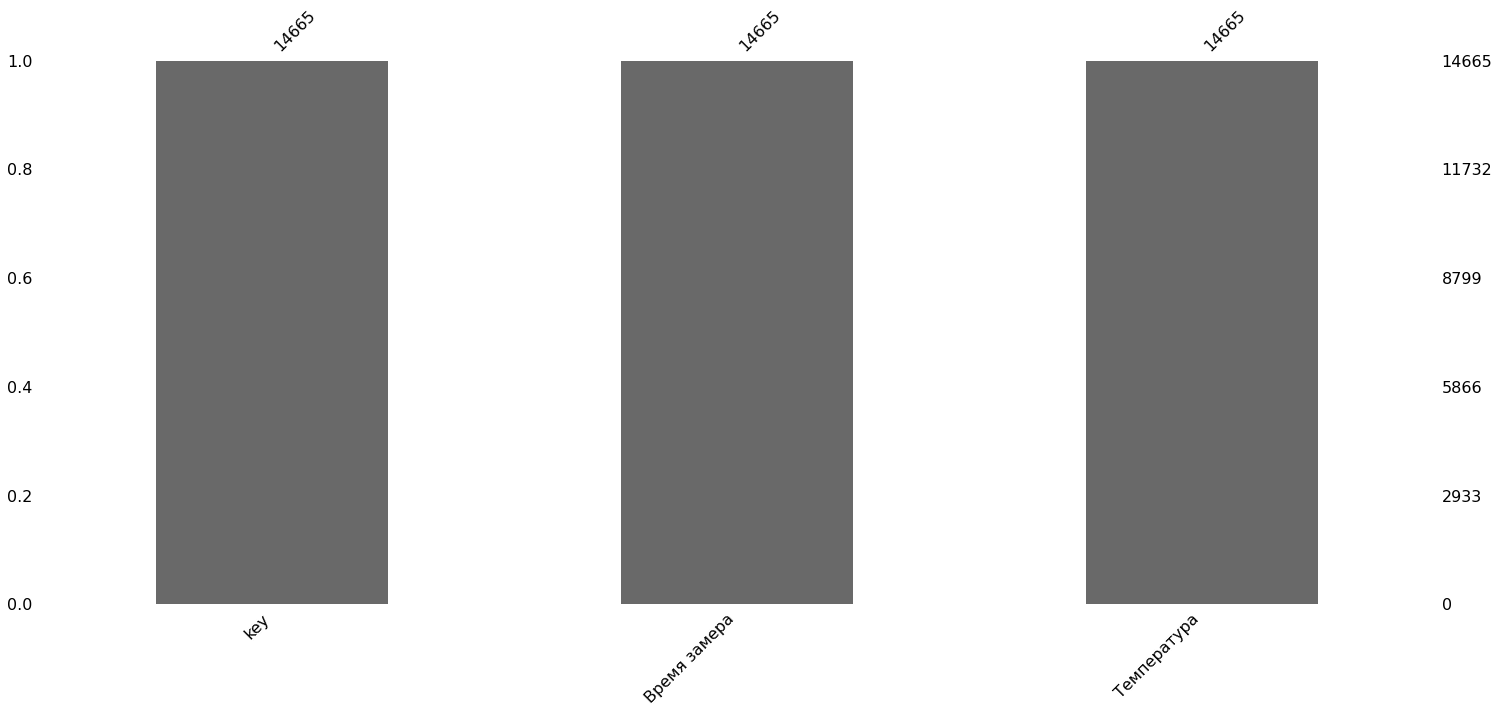

In [49]:
data_temp = data_temp.dropna()
msn.bar(data_temp)

**Датасет очищен от пропусков. Строки, которые содержат пропуски удалены, так как искусственно восстанавливать пропуски нельзя, будущая модель будет обучаться на искусственных данных, что не является корректным.**

In [50]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [51]:
# Исключаем сплавы с одним замером
valid_keys = data_temp['key'].value_counts()[data_temp['key'].value_counts() > 1].index
data_temp = data_temp[data_temp['key'].isin(valid_keys)]

In [52]:
data_temp

key        Время замера  Температура
0         1 2019-05-03 11:02:04       1571.0
1         1 2019-05-03 11:07:18       1604.0
2         1 2019-05-03 11:11:34       1618.0
3         1 2019-05-03 11:18:04       1601.0
4         1 2019-05-03 11:25:59       1606.0
...     ...                 ...          ...
13921  2499 2019-08-10 13:33:21       1569.0
13922  2499 2019-08-10 13:41:34       1604.0
13923  2499 2019-08-10 13:46:28       1593.0
13924  2499 2019-08-10 13:54:56       1588.0
13925  2499 2019-08-10 13:58:58       1603.0

[13924 rows x 3 columns]

In [53]:
last_temp = (
    data_temp.sort_values(by='Время замера')  # Сортируем по времени
    .groupby('key')
    .last()  # Берем последнюю запись для каждой группы
    .reset_index()
)

last_temp = last_temp[['key', 'Температура']].rename(columns={'Температура': 'target'})

In [54]:
last_temp

key  target
0        1  1613.0
1        2  1602.0
2        3  1599.0
3        4  1625.0
4        5  1602.0
...    ...     ...
2470  2495  1591.0
2471  2496  1591.0
2472  2497  1589.0
2473  2498  1594.0
2474  2499  1603.0

[2475 rows x 2 columns]

**Выделено `target` значение**

In [55]:
aggregated_temp = (
    data_temp.sort_values(by='Время замера')
    .groupby('key')
    .apply(lambda x: x.iloc[:-1]['Температура'].agg(['mean', 'min', 'max']))
    .reset_index()
)

aggregated_temp.columns = ['key', 'mean_temp', 'min_temp', 'max_temp']

**Агрегация всех остальных значений температуры.**

In [56]:
result = pd.merge(last_temp, aggregated_temp, on='key', how='left')
result

key  target    mean_temp  min_temp  max_temp
0        1  1613.0  1600.000000    1571.0    1618.0
1        2  1602.0  1587.750000    1577.0    1604.0
2        3  1599.0  1598.000000    1596.0    1600.0
3        4  1625.0  1614.750000    1601.0    1623.0
4        5  1602.0  1585.750000    1576.0    1592.0
...    ...     ...          ...       ...       ...
2470  2495  1591.0  1581.250000    1570.0    1590.0
2471  2496  1591.0  1578.666667    1554.0    1595.0
2472  2497  1589.0  1574.666667    1571.0    1577.0
2473  2498  1594.0  1583.200000    1570.0    1593.0
2474  2499  1603.0  1588.500000    1569.0    1604.0

[2475 rows x 5 columns]

In [57]:
time_diff = data_temp.groupby('key')['Время замера'].agg(
    first_time='min',
    last_time='max'
).reset_index()

In [58]:
time_diff['time_interval'] = (time_diff['last_time'] - time_diff['first_time']).dt.total_seconds()
time_diff

key          first_time           last_time  time_interval
0        1 2019-05-03 11:02:04 2019-05-03 11:30:38         1714.0
1        2 2019-05-03 11:34:04 2019-05-03 11:55:09         1265.0
2        3 2019-05-03 12:06:44 2019-05-03 12:35:57         1753.0
3        4 2019-05-03 12:39:27 2019-05-03 12:59:47         1220.0
4        5 2019-05-03 13:11:03 2019-05-03 13:36:39         1536.0
...    ...                 ...                 ...            ...
2470  2495 2019-08-10 11:27:47 2019-08-10 11:50:47         1380.0
2471  2496 2019-08-10 11:56:48 2019-08-10 12:25:13         1705.0
2472  2497 2019-08-10 12:37:26 2019-08-10 12:53:28          962.0
2473  2498 2019-08-10 12:58:11 2019-08-10 13:23:31         1520.0
2474  2499 2019-08-10 13:33:21 2019-08-10 13:58:58         1537.0

[2475 rows x 4 columns]

In [59]:
result = pd.merge(result[['key', 'target', 'mean_temp']], time_diff.drop(['first_time', 'last_time'], axis=1), on='key')

In [60]:
result

key  target    mean_temp  time_interval
0        1  1613.0  1600.000000         1714.0
1        2  1602.0  1587.750000         1265.0
2        3  1599.0  1598.000000         1753.0
3        4  1625.0  1614.750000         1220.0
4        5  1602.0  1585.750000         1536.0
...    ...     ...          ...            ...
2470  2495  1591.0  1581.250000         1380.0
2471  2496  1591.0  1578.666667         1705.0
2472  2497  1589.0  1574.666667          962.0
2473  2498  1594.0  1583.200000         1520.0
2474  2499  1603.0  1588.500000         1537.0

[2475 rows x 4 columns]

**По итогу небольших преобразований датасета было выделено target значение температуры, то есть последняя измеренная для каждой партии, также ещё один возможный признак - интервал времени между первым и последним замерами, а также среднее значение температуры предыдущих замеров.**

### data_wire

In [61]:
data_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

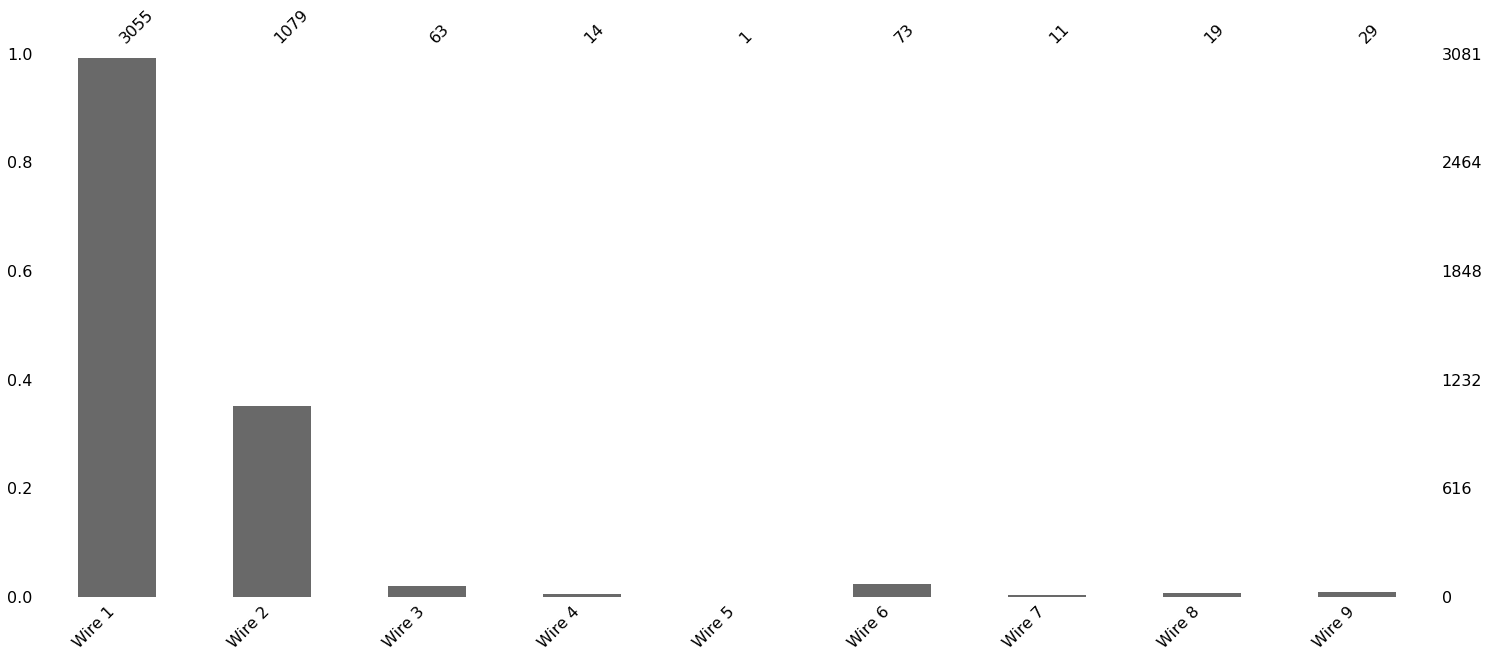

In [62]:
msn.bar(data_wire.drop('key', axis=1))
plt.show()

**Чаще всего используют проволочный материал 1 вида, реже всего в работу идет 4, 5, 7 виды.**

**Преобразуем эти признаки аналогично признакам в таблице data_bulk, найдем сумму и количество видов.**

In [63]:
data_wire['wire_sum'] = data_wire.drop('key', axis=1).sum(axis=1)
data_wire['wire_count'] = data_wire.drop(['key', 'wire_sum'], axis=1).notnull().sum(axis=1)

In [64]:
data_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9   wire_sum  wire_count  
0     NaN  60.059998           1  
1     NaN  96.052315           1  
2     NaN  91.160157           1  
3     NaN  89.063515           1  
4     NaN  98.352796           2

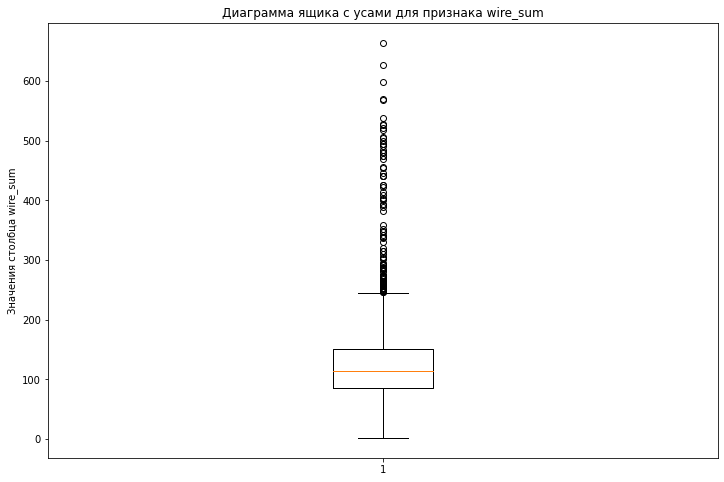

In [65]:
numeric_features(data_wire, 'wire_sum')

**Размеры выбросов превышают 600 единиц общего объема проволочных материалов. Среднее значение расположено около 100 единиц.**

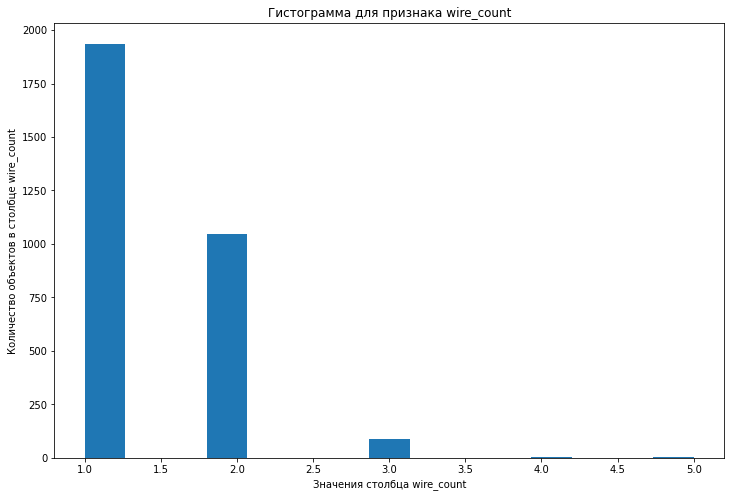

In [66]:
frequency_features(data_wire, 'wire_count', bins=15)

**В большинстве случаев добавляют 1 или 2 проволочных материала, очень редко по 4 и 5.**

### data_wire_time

In [67]:
data_wire_time.head()

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

**Структера пропусков у датасета такая же как и у `data_wire`. Преобразуем его также как и `data_bulk_time`.**

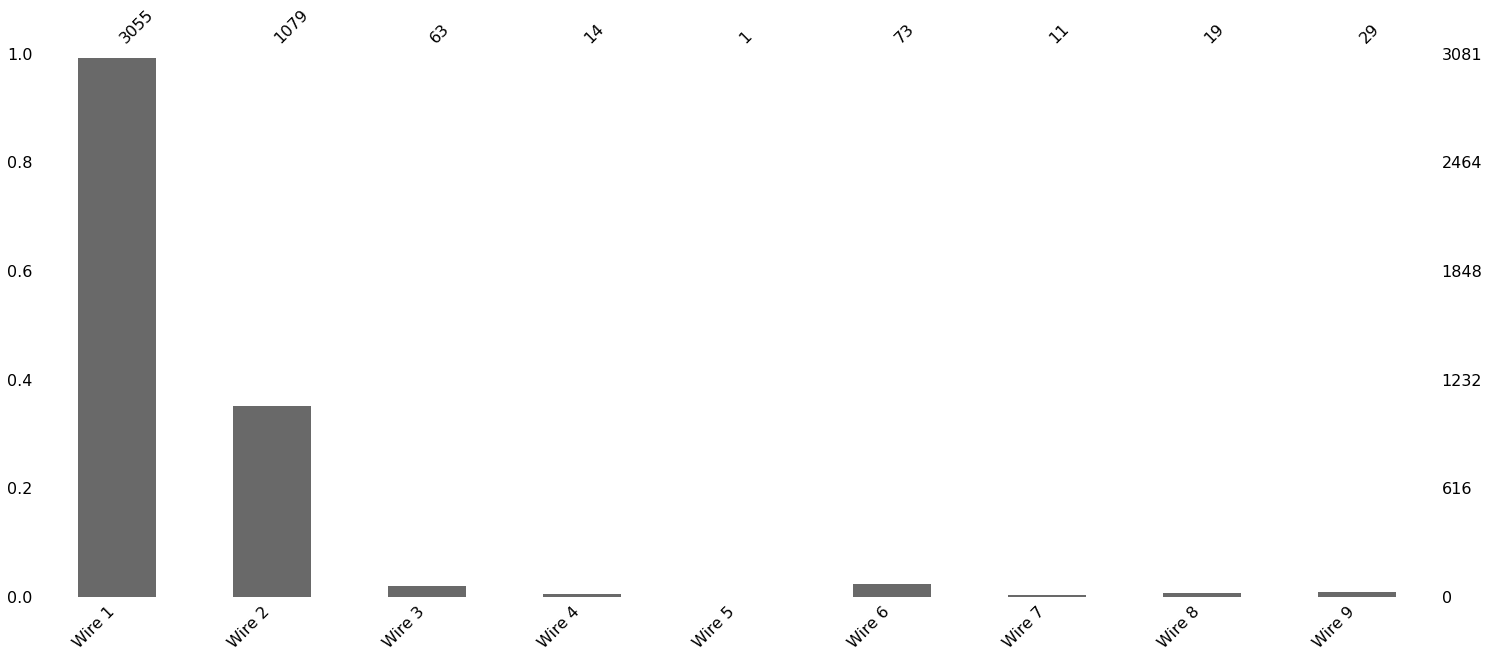

In [68]:
msn.bar(data_wire_time.drop('key', axis=1))
plt.show()

In [69]:
# Изменим тип столбцов с датами
for col in data_wire_time.drop('key', axis=1).columns:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col])

In [70]:
#Проверим корректность
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [71]:
#Создадим признак - промежуток времени между 1 и последним добавлением bulk
data_wire_time['interval_wire'] = (data_wire_time.drop('key', axis=1).
                                apply(lambda row: (row.max() - row.min()).total_seconds(), axis=1))

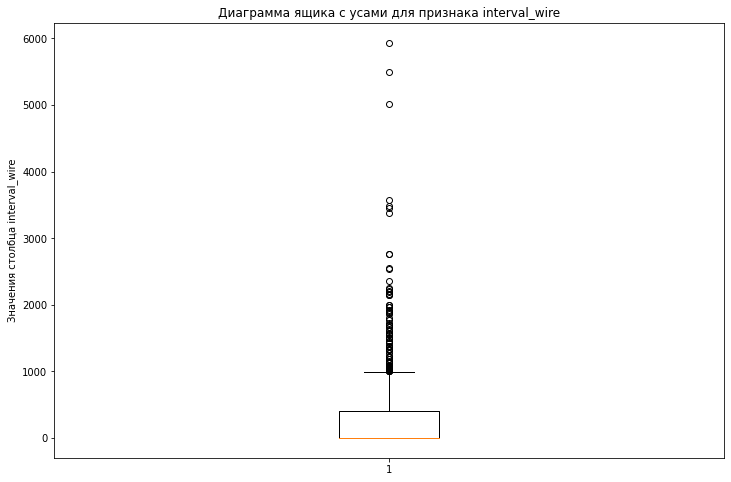

In [72]:
numeric_features(data_wire_time, 'interval_wire')

**Как видим среднее значение интервала практически в 0. Это следует из того, что чаще всего добавляют 1 и 2 проволочных материала. Этот признак при обучении модели использовать не будем, он мало информативный.**

**`Вывод по второму шагу`: По итогу второго шага работы подробно изучен каждый датасет с помощью гистограмм и ящиков с усами. Из датасета `data_temp` выделено target значение.**

 - data_arc: добавлен признак длительности нагрева, удалена аномалия и агрегированы значения мощности;
 - data_bulk: вся нужная информация теперь представлена в виде двух столбцов - суммарный объем материалов и количество видов;
 - data_bulk_time: расчитан интервал времени между первым и последним добавлением материалов;
 - data_temp: агрегированы промежуточные значения температур и моментов времени;
 - data_wire: обработан аналогично data_bulk;
 - data_wire_time: обработан аналогично data_bulk_time, но после построения ящика с усами стало понятно, что преобразование информации не информативно.

## Объединение таблиц

In [73]:
data_all = pd.merge(data_arc_agg, 
                    data_bulk[['key', 'bulk_sum', 'bulk_count']],
                    on='key')

In [74]:
data_all = pd.merge(data_all, 
                    data_bulk_time[['key', 'interval_bulk']],
                    on='key')

In [75]:
data_all = pd.merge(data_all, 
                    data_gas,
                    on='key')

In [76]:
data_all = pd.merge(data_all, 
                    result,
                    on='key')

In [77]:
data_all = pd.merge(data_all, 
                    data_wire[['key', 'wire_sum', 'wire_count']],
                    on='key')

In [78]:
data_all.shape

(2329, 13)

**`Вывод по третьему шагу`: вся нужна информация объединена в один датасет. Итоговый объем составил 2329 объектов и 11 признаков без учета ключа.**

## Исследование итогового датафрейма

### Исследовательский анализ

In [79]:
def vis_data_all(data, features, color):
    for column, color in zip(data[features].columns, color):
        sns.kdeplot(data[column], label=column, fill=True, color=color)

    # Настройка графика
    plt.title("Построение графика KDE", fontsize=16)
    plt.xlabel("Значения", fontsize=14)
    plt.ylabel("Плотность", fontsize=14)
    plt.legend(title="Признак", fontsize=12)
    plt.show()

In [80]:
RANDOM_STATE = 121124
X, y = data_all.drop('target', axis=1), data_all['target']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

In [82]:
(X_train.shape, X_test.shape)

((1746, 12), (583, 12))

In [83]:
X_train.head()

key  act_power  re_power  time_heating  bulk_sum  bulk_count  \
377    421   1.143725  0.812354    150.800000     661.0           4   
1303  1399   1.273195  1.035540    139.285714     411.0           3   
1356  1454   1.386049  0.949228    113.500000     570.0           4   
943   1024   1.318827  0.834401    263.000000     978.0           5   
763    829   1.004372  0.741639    220.800000     608.0           3   

      interval_bulk      Газ 1    mean_temp  time_interval    wire_sum  \
377           706.0   6.298236  1590.600000         1789.0  185.582815   
1303          726.0   2.406848  1602.714286         2718.0  190.620567   
1356         1623.0  13.689328  1598.833333         3173.0  153.223206   
943           672.0  16.108901  1578.500000         1675.0   60.044403   
763          3303.0   4.204058  1596.400000         4717.0   61.120799   

      wire_count  
377            2  
1303           2  
1356           1  
943            1  
763            1

**Исследовать будем `train` выборку, чтобы по необходимости улучшить её для тренировки, `test` изменять нельзя, так как это имитация новых данных, которые модель не видела, а такие данные могут принимать любые значения.**

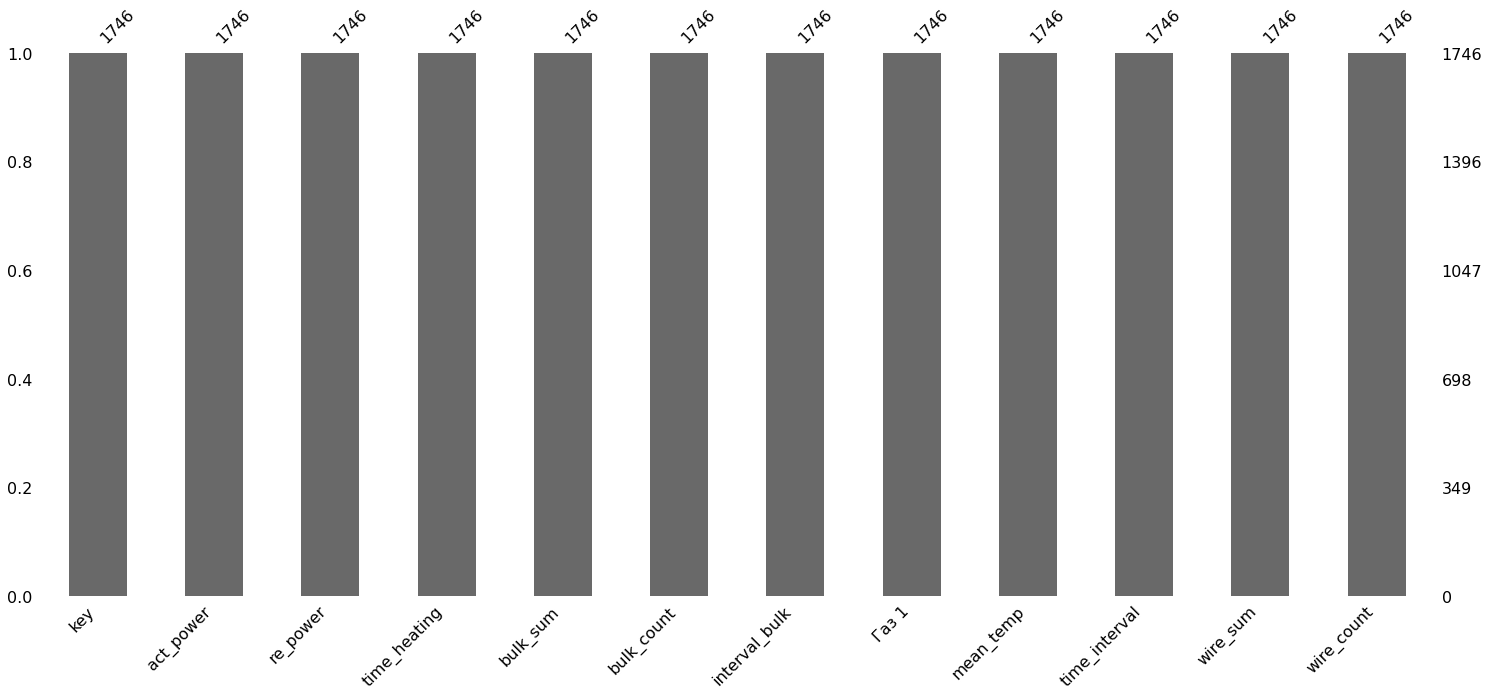

In [84]:
msn.bar(X_train)
plt.show()

In [85]:
X_train.duplicated().sum()

0

**Пропусков и дубликатов не обнаружено.**

**Графики имеют разный цветы, чтобы выделить назначение отдельных признаков:**
- `зелёный`: отображает временные признаки;
- `желтый`: агрегированные данные по сумме и среднему значению;
- `красный` и `синий`: не преобразованные признаки.

Количественные признаки `bulk_count` и `wire_count` были изучены ранее.

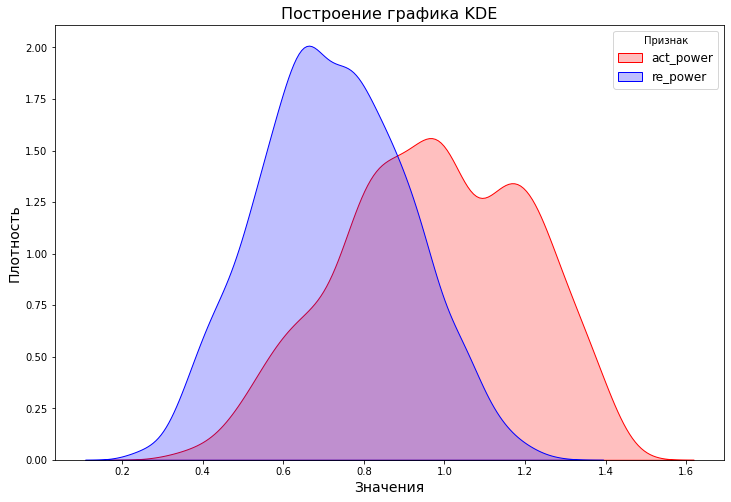

In [86]:
vis_data_all(X_train, ['act_power', 're_power'], ['r', 'b'])

1. **Красное распределение (`act_power`)**:
   - Распределение смещено правее по сравнению с синим.
   - Имеет более выраженную "плотность" в диапазоне около **0.8 - 1.2**.
   - Указывает, что большинство значений активной мощности сосредоточены в этом диапазоне.

2. **Синие распределение (`re_power`)**:
   - Распределение смещено левее относительно красного.
   - Имеет пик в области около **0.6 - 1.0**, а после снижается более плавно.
   - Указывает на большую концентрацию значений реактивной мощности ближе к нижним значениям.

3. **Общие характеристики**:
   - Графики перекрываются в диапазоне **0.6 - 1.2**, что говорит о том, что в этом интервале обе величины имеют схожую частоту появления.
   - Плотности различны по ширине: синее распределение выглядит более узким, что может указывать на меньшую дисперсию значений.

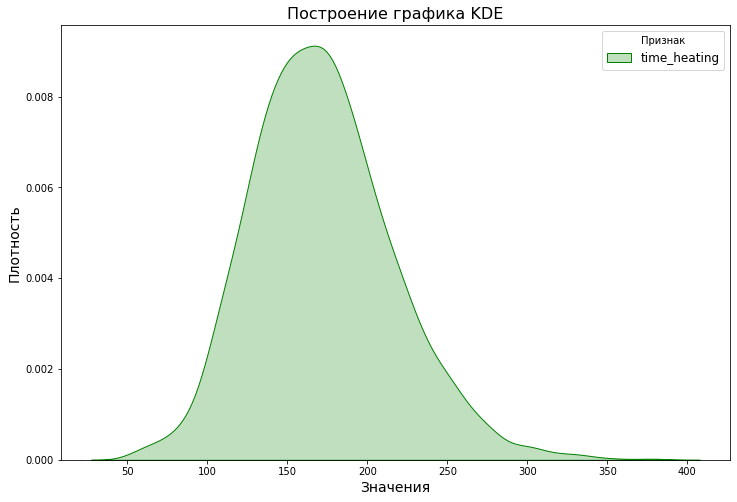

In [87]:
vis_data_all(X_train, ['time_heating'], ['green'])

   - **Распределение**: Похоже на нормальное (гауссово) распределение с явным центральным пиком.
   - **Центр распределения**: Основная масса значений сосредоточена вокруг диапазона 150–200.
   - Значение `time_heating` (время нагрева) в большинстве случаев находится в этом диапазоне.
   - Есть небольшое количество значений в хвостах (менее 100 и более 300), но их влияние минимально.

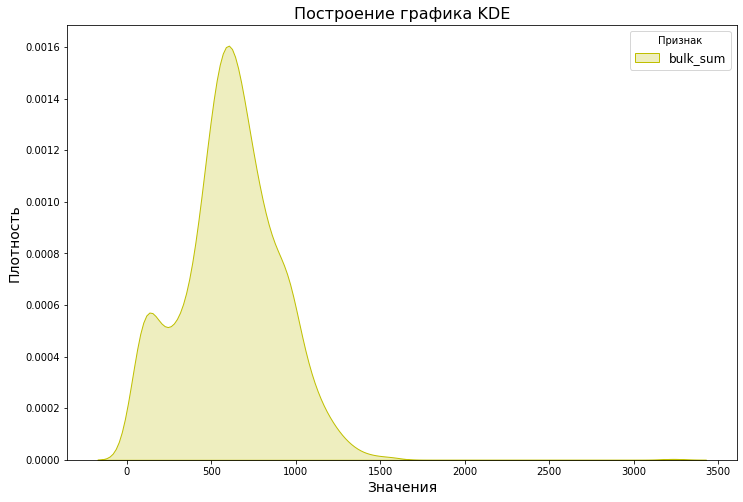

In [88]:
vis_data_all(X_train, ['bulk_sum'], ['y'])


   - **Распределение**: Явно асимметричное, с длинным правым хвостом.
   - **Центр распределения**: Большая часть значений сосредоточена около 500–1000, но присутствуют редкие выбросы до 3500.
   - Признак `bulk_sum` (суммарное количество материала) имеет длинный хвост, что может свидетельствовать о редких случаях значительного расхода материала.


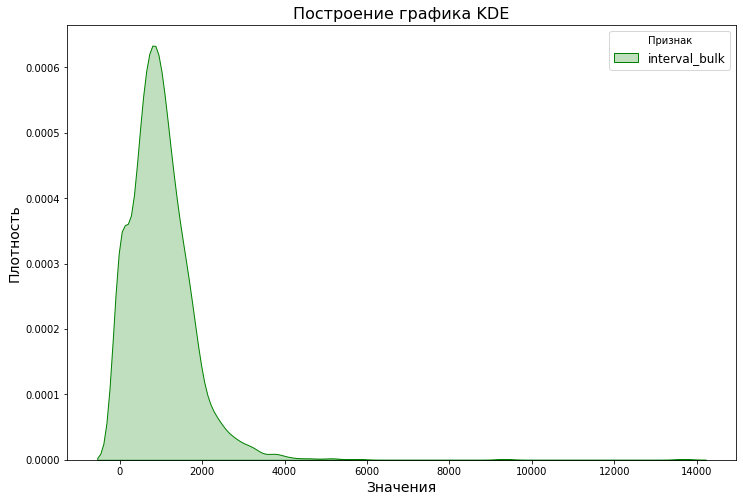

In [89]:
vis_data_all(X_train, ['interval_bulk'], ['green'])

 - **Распределение**: Сильно асимметричное, с длинным правым хвостом.
 - **Центр распределения**: Основная масса значений находится около 0–2000, но есть выбросы до 14 000.
 - Признак `interval_bulk` (интервал между событиями) имеет значительные выбросы.
 - Преобладание значений в узком диапазоне (0–2000) может свидетельствовать о высокой концентрации в стандартных интервалах, но редкие события сильно удлиняют хвост.
 - Для обработки можно использовать преобразования (например, логарифмическое) или отфильтровать редкие выбросы.

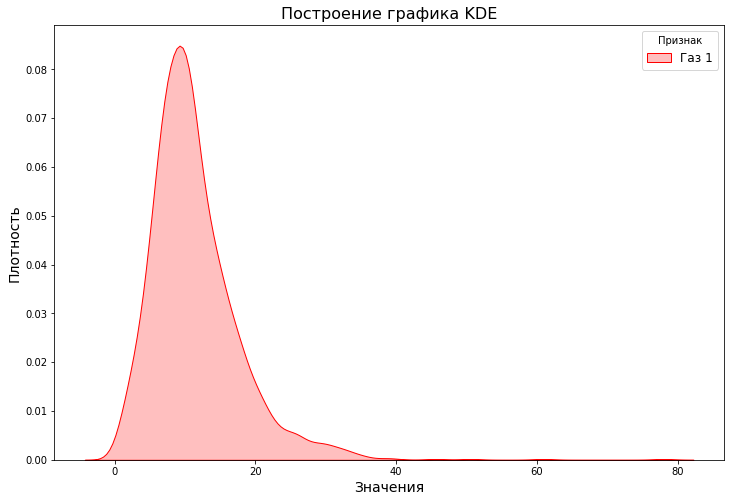

In [90]:
vis_data_all(X_train, ['Газ 1'], ['r'])


 - Распределение асимметричное с положительным перекосом.
 - Основная масса значений находится в диапазоне от 0 до 30.
 - Значения выше 40 встречаются редко, а экстремальные значения (выше 60) практически отсутствуют.
 - Можно предположить, что большинство процессов связано с умеренным использованием газа.

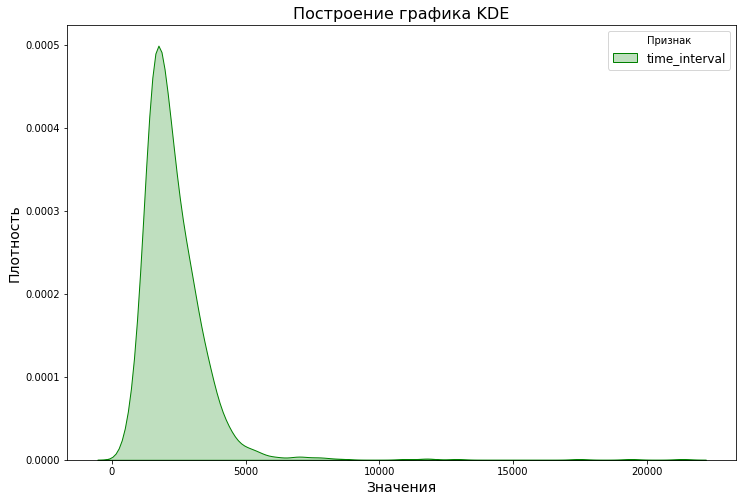

In [91]:
vis_data_all(X_train, ['time_interval'], ['green'])

- Распределение также имеет сильный положительный перекос.
- Основная масса временных интервалов сконцентрирована в районе значений до 2000.
- После значения 5000 плотность резко падает, что говорит о редкости больших временных интервалов.
- Экстремальные значения до 20,000 указывают на редкие события с очень большими задержками.

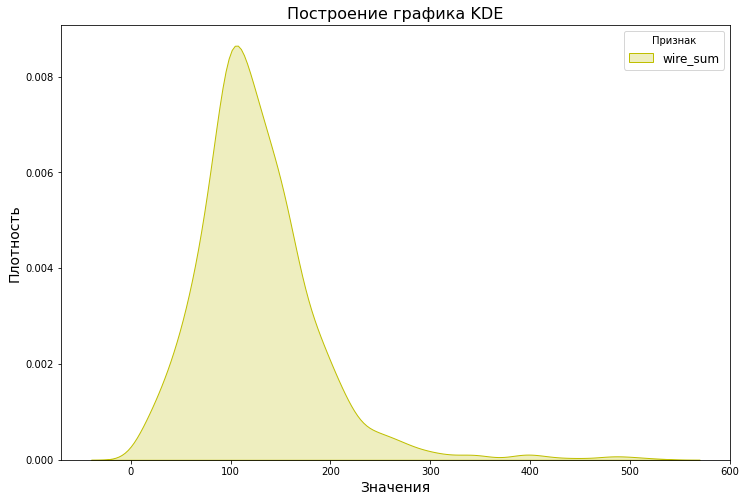

In [92]:
vis_data_all(X_train, ['wire_sum'], ['y'])

- Основная масса объемов сконцентрирована в районе значений до 250.
- После значения 250 плотность резко падает, что говорит о редкости больших объемов материалов, которые добавляются в сплав.

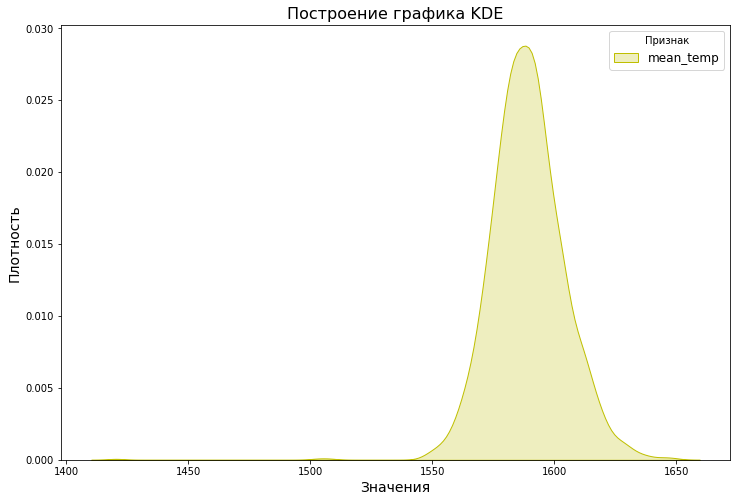

In [93]:
vis_data_all(X_train, ['mean_temp'], ['y'])

- Основная масса средних температур сконцентрирована в районе значений от 1550 до 1650.
- от 1400 до 1550  наблюдается очень редкое появление сплавов с такой средней температурой опыта.

### Корреляционный анализ

interval columns not set, guessing: ['key', 'act_power', 're_power', 'time_heating', 'bulk_sum', 'bulk_count', 'interval_bulk', 'Газ 1', 'mean_temp', 'time_interval', 'wire_sum', 'wire_count']


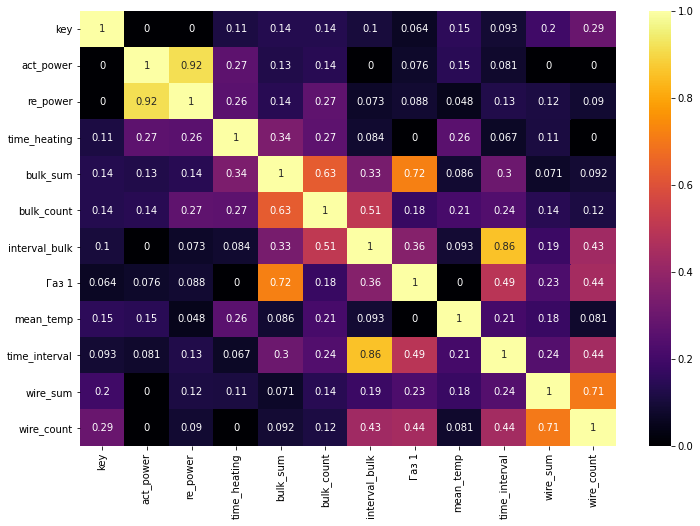

In [94]:
sns.heatmap(X_train.phik_matrix(), annot=True, cmap='inferno')
plt.show()

**По матрице корреляции можно сказать, что сильную связь имеют признаки мощности, поэтому одну из них можно убрать. А также суммарные материалы `bulk` с их количеством и газом, отсюда можно убрать сам `bulk_sum`. Есть корреляция между признаками времени суммарное время добавления  `bulk` материалов и `wire`, аналогично один из этих признаков можно убрать.**

In [95]:
X_train = X_train.drop(['key', 're_power', 'bulk_sum', 'time_interval'], axis=1)
X_test = X_test.drop(['key', 're_power', 'bulk_sum', 'time_interval'], axis=1)

interval columns not set, guessing: ['act_power', 'time_heating', 'bulk_count', 'interval_bulk', 'Газ 1', 'mean_temp', 'wire_sum', 'wire_count']


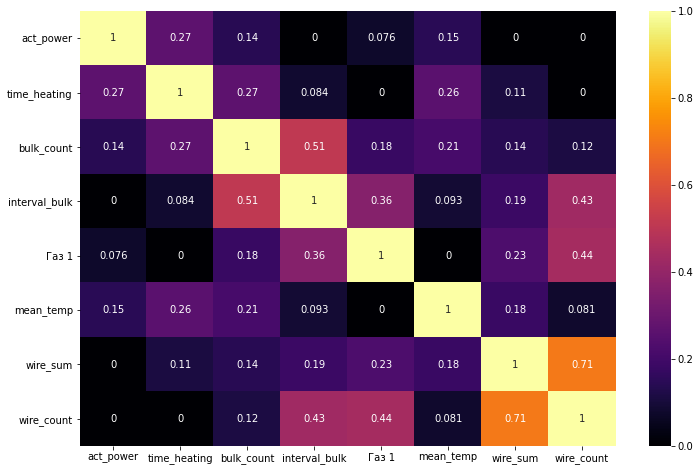

In [96]:
sns.heatmap(X_train.phik_matrix(), annot=True, cmap='inferno')
plt.show()

**Сейчас матрица корреляции выглядит иначе и взаимосвязи между признаками почти нету.**

**`Вывод по четвертому шагу`: На этом шаге  был изучен тренировочный датасет. Рассмотрены распределеня каждого признака. Построена матрица корреляции, которая показала наличие близкой связи между тремя признаками, которые в дальнейшем были удалены.**

## Построение модели

In [97]:
num_columns = X_train.columns
num_columns

Index(['act_power', 'time_heating', 'bulk_count', 'interval_bulk', 'Газ 1',
       'mean_temp', 'wire_sum', 'wire_count'],
      dtype='object')

In [98]:
data_preprocessor = ColumnTransformer([('num', StandardScaler(), num_columns),
                                     ],
                                      remainder='passthrough')

### Пайплайн моделей

In [99]:
# Итоговый пайплайн с моделью
final_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [100]:
param_grid = [{'models':[DecisionTreeRegressor(random_state=RANDOM_STATE)],
               'models__max_depth': range(2, 20),
               'models__max_features': range(2, 20),
               'preprocessor__num': [StandardScaler(), 'passthrough']
              },
              {'models':[LinearRegression()],
               'preprocessor__num': [StandardScaler(), 'passthrough']
              }
             ]

In [101]:
# Поиск лучшей модели с лучшими гиперпараметрами
randomized_search = RandomizedSearchCV(
    final_pipeline, 
    param_grid, 
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [102]:
randomized_search.fit(X_train, y_train)
best_model_one = randomized_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_model_one)
print('Метрика лучшей модели на кросс-валидации:',  abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['act_power', 'time_heating', 'bulk_count', 'interval_bulk', 'Газ 1',
       'mean_temp', 'wire_sum', 'wire_count'],
      dtype='object'))])),
                ('models',
                 DecisionTreeRegressor(max_depth=7, max_features=4,
                                       random_state=121124))])
Метрика лучшей модели на кросс-валидации: 6.404026404053586


In [103]:
start_time = time.time()
best_model_one.fit(X_train, y_train)
finish_time = time.time() - start_time

In [104]:
y_train_pred = best_model_one.predict(X_train)
mae_one = mean_absolute_error(y_train, y_train_pred)
print('Метрика MAE на тренировочной выборке:', mae_one)

Метрика MAE на тренировочной выборке: 4.511457085811973


In [105]:
data_result = {
    'model': ['DecisionTreeRegressor'],
    'Время обучения':[finish_time],
    'Cross-val': [abs(randomized_search.best_score_)],
    'Train': [mae_one]
}
data_result = pd.DataFrame(data_result)

In [106]:
data_result

model  Время обучения  Cross-val     Train
0  DecisionTreeRegressor         0.00927   6.404026  4.511457

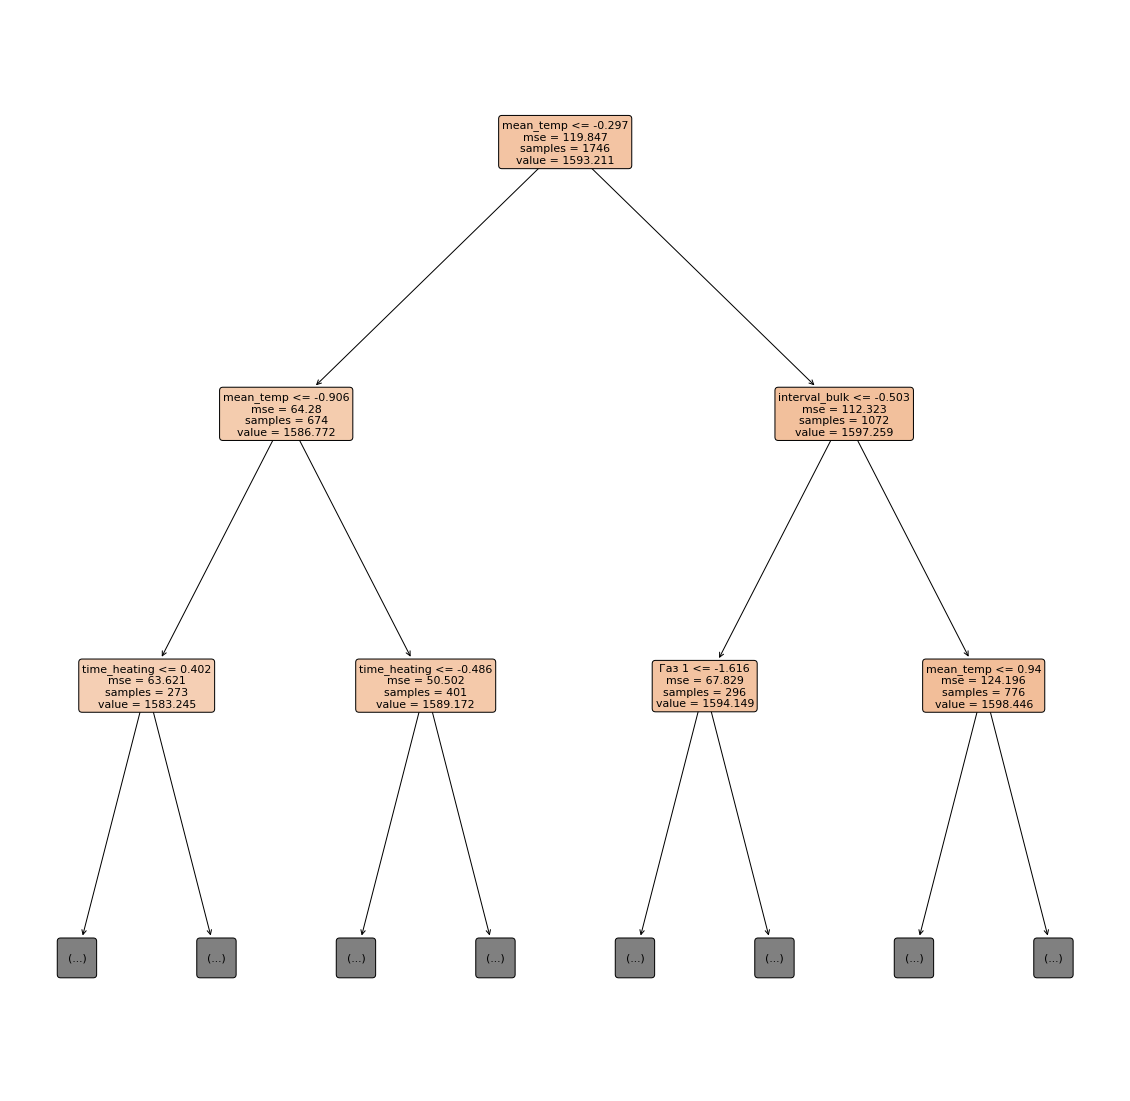

In [107]:
fig = plt.figure(figsize=(20,20))
_ = tree.plot_tree(best_model_one['models'],
                   max_depth=2,
                   feature_names=X_train.columns,
                   rounded=True,
                   filled=True)

**Пайплайн дерева решений с гиперпараметрами и линейной регрессией выявил лучшую модель - DecisionTreeRegressor(max_depth=7, max_features=4, random_state=121124), выше отрисовано это дерево только с глубиной 2 для лучшей читаемости. Метрика на кросс-валидации получилась 6,4, а на тренировочной выборке 4,5. Далее сравним эти результаты с ансамблем деревьев.**

### CatBoost

In [108]:
# Итоговый пайплайн с моделью
final_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostRegressor(random_seed=RANDOM_STATE))
])

In [109]:
param_grid = [{'models':[CatBoostRegressor(random_seed=RANDOM_STATE)],
               'models__learning_rate': [0.01, 0.05, 0.1],
               'models__depth': [4, 6, 8],
               'preprocessor__num': [StandardScaler(), 'passthrough']
              }
             ]

In [110]:
randomized_search = RandomizedSearchCV(
    final_pipeline, 
    param_grid, 
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [111]:
randomized_search.fit(X_train, y_train)
# Лучшая модель
best_model_ensemble = randomized_search.best_estimator_
print("Лучшие параметры:", randomized_search.best_params_)

0:	learn: 10.4585345	total: 53.9ms	remaining: 53.8s
1:	learn: 10.0857839	total: 60.9ms	remaining: 30.4s
2:	learn: 9.7881442	total: 67.9ms	remaining: 22.6s
3:	learn: 9.4599264	total: 74.9ms	remaining: 18.7s
4:	learn: 9.1546631	total: 81.9ms	remaining: 16.3s
5:	learn: 8.9123045	total: 88.8ms	remaining: 14.7s
6:	learn: 8.6777195	total: 95.9ms	remaining: 13.6s
7:	learn: 8.4572401	total: 102ms	remaining: 12.7s
8:	learn: 8.2495201	total: 109ms	remaining: 12s
9:	learn: 8.0996442	total: 115ms	remaining: 11.4s
10:	learn: 7.9545582	total: 122ms	remaining: 10.9s
11:	learn: 7.7986487	total: 128ms	remaining: 10.6s
12:	learn: 7.6687341	total: 135ms	remaining: 10.2s
13:	learn: 7.5474403	total: 141ms	remaining: 9.96s
14:	learn: 7.4834040	total: 142ms	remaining: 9.33s
15:	learn: 7.3639828	total: 147ms	remaining: 9.03s
16:	learn: 7.2695242	total: 151ms	remaining: 8.74s
17:	learn: 7.2071094	total: 156ms	remaining: 8.48s
18:	learn: 7.1187043	total: 160ms	remaining: 8.24s
19:	learn: 7.0360865	total: 164ms	

In [112]:
start_time = time.time()
best_model_ensemble.fit(X_train, y_train)
finish_time  = time.time() - start_time

0:	learn: 10.9049267	total: 7.71ms	remaining: 7.7s
1:	learn: 10.8618640	total: 12.3ms	remaining: 6.13s
2:	learn: 10.8225831	total: 16.9ms	remaining: 5.61s
3:	learn: 10.7795555	total: 21.3ms	remaining: 5.3s
4:	learn: 10.7379128	total: 25.6ms	remaining: 5.09s
5:	learn: 10.6996849	total: 29.9ms	remaining: 4.95s
6:	learn: 10.6580447	total: 34.3ms	remaining: 4.87s
7:	learn: 10.6180940	total: 38.8ms	remaining: 4.81s
8:	learn: 10.5764555	total: 43.1ms	remaining: 4.75s
9:	learn: 10.5399637	total: 47.4ms	remaining: 4.69s
10:	learn: 10.5038771	total: 52.5ms	remaining: 4.72s
11:	learn: 10.4665912	total: 57.3ms	remaining: 4.72s
12:	learn: 10.4264923	total: 62.1ms	remaining: 4.71s
13:	learn: 10.3852401	total: 66.5ms	remaining: 4.68s
14:	learn: 10.3472789	total: 70.7ms	remaining: 4.64s
15:	learn: 10.3094816	total: 75.3ms	remaining: 4.63s
16:	learn: 10.2693584	total: 79.5ms	remaining: 4.6s
17:	learn: 10.2313311	total: 83.8ms	remaining: 4.57s
18:	learn: 10.2001501	total: 88ms	remaining: 4.54s
19:	lear

In [113]:
y_train_pred = best_model_ensemble.predict(X_train)
mae_two = mean_absolute_error(y_train, y_train_pred)
print('Метрика MAE на тренировочной выборке:', mae_two)

Метрика MAE на тренировочной выборке: 3.8464868854887584


In [114]:
ensemble_result = pd.DataFrame([{'model': 'CatBoostRegressor',
                                'Время обучения':finish_time,
                                'Cross-val': abs(randomized_search.best_score_),
                                'Train': mae_two}])
data_result = pd.concat([data_result, ensemble_result], ignore_index=True)

In [115]:
data_result

model  Время обучения  Cross-val     Train
0  DecisionTreeRegressor        0.009270   6.404026  4.511457
1      CatBoostRegressor        5.158061   5.272664  3.846487

In [116]:
learning_curve = best_model_ensemble['models'].evals_result_

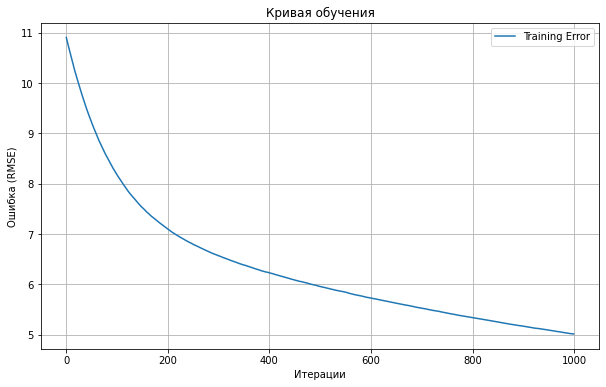

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(learning_curve['learn']['RMSE'], label='Training Error')
plt.xlabel('Итерации')
plt.ylabel('Ошибка (RMSE)')
plt.title('Кривая обучения')
plt.legend()
plt.grid()
plt.show()

**Проанализировав таблицу `data_result` можно сказать, что ансамбль справился лучше как и на кросс-валидации, так и на тренировочной выборке, поэтому для оценки метрики на test данных будем использовать CatBoost, время обучения конечно намного лучше у обычного дерева, но результат в 6 секунд у ансамбля тоже неплох. Также отрисован график уменьшения ошибки RMSE ансамбля в зависимости от итерации, ансамбль улучшает свои предсказания за счет оптимизиции метрики RMSE.**

### Используем на test

In [118]:
y_pred_test = best_model_ensemble.predict(X_test)
print(f'MAE лучшей модели на тестовой выборке {mean_absolute_error(y_test, y_pred_test)}')

MAE лучшей модели на тестовой выборке 5.763301868725881


In [119]:
dummy = DummyRegressor()
start_time = time.time()
dummy.fit(X_train, y_train)
finish_time = time.time() - start_time

In [120]:
y_train_pred = dummy.predict(X_train)
y_test_pred = dummy.predict(X_test)
print('MAE Dummy модели на тренировочной выборке ', mean_absolute_error(y_train, y_train_pred))
print('MAE Dummy модели на тестовой выборке ', mean_absolute_error(y_test, y_test_pred))

MAE Dummy модели на тренировочной выборке  7.875534194342424
MAE Dummy модели на тестовой выборке  8.65063197624956


In [121]:
dummy_result = pd.DataFrame([{'model': 'DummyRegressor',
                                'Время обучения':finish_time,
                                'Cross-val': 'Nan',
                                'Train': mean_absolute_error(y_train, y_train_pred)}])
data_result = pd.concat([data_result, dummy_result], ignore_index=True)

In [122]:
data_result

model  Время обучения Cross-val     Train
0  DecisionTreeRegressor        0.009270  6.404026  4.511457
1      CatBoostRegressor        5.158061  5.272664  3.846487
2         DummyRegressor        0.000538       Nan  7.875534

**Ансамбль дал удовлетворительные предсказания на test выборке, MAE=5,7. Также необходимо проверить модель на адекватность её испльзования с помощью Dummy. Действительно Dummy показал самое большое MAE на train выборке.**

## Интерпретация модели

In [123]:
best_model_ensemble['models']

In [124]:
explainer = shap.Explainer(best_model_ensemble['models'])
shap_values = explainer(X_test)

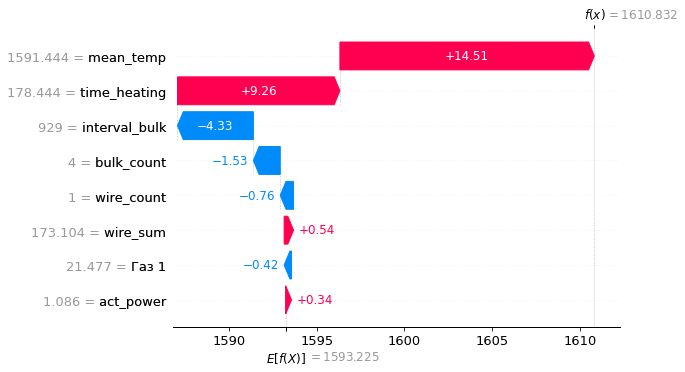

In [125]:
shap.plots.waterfall(shap_values[0])

**На Waterfall диаграмме наблюдаем как каждый признак влияет на результат предсказания. Средняя температура промежуточных измерений и полное время нагрева дугой будут смещать предсказание к высоким результатам. Полное время подачи bulk материалов и количество их разнообразия, а также количество разнообразия проволочных материалов наоборот стараются компенсировать и смещают предсказания к низким результатам.**

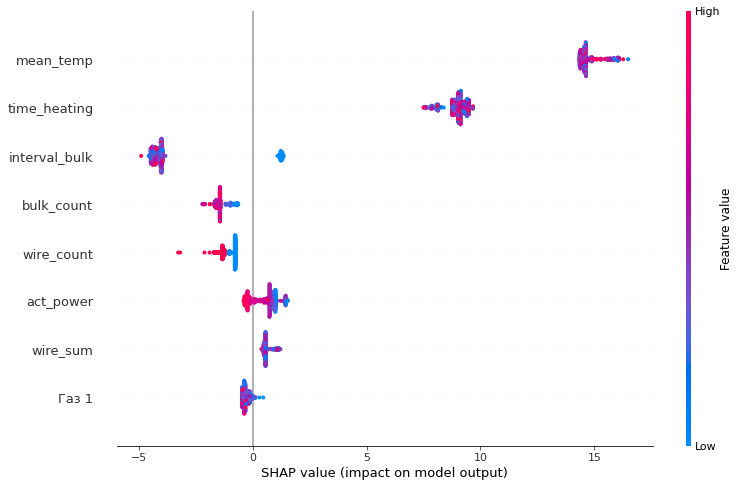

In [126]:
shap.plots.beeswarm(shap_values, plot_size=(12, 8))

**На Beeswarm диаграмме можно заметить, что каждый признак дает увернность модели, значения shap практически не разбросаны, а сконцентрированы в одном месте. Рассмотрим подробнее выше замеченные признаки.**

 - Среднняя температура промежуточных измерений: Практически любое значение средней температуры дает высокое значение температуры, но модель делает предсказание уверенно;
 - Полное время нагрева дугой: результат такой же. Что большое время, что маленькое дает модели повод предсказывать завышенное значение таргета;
 - Общее количество проволочных материалов: можно сказать, что при любых значениях этого признака, он будет тянуть результаты модели к меньшему результату. Анализ времени общего нагрева аналогичен
 - Разнообразие видов bulk материалов: стоит отметить этот признак, так как при большом разнообразии видов bulk модель тянет температуру к меньшим значениям, чем при маленьком количестве разнообразия.
 - Также стоит отметить активную мощность, где при высоких значениях модель будет склоняться к меньшему таргету, а при маленьком значении мощности к большему значению таргета.

## Итоговый вывод


<span style="font-size:20px;">Этап 1: Просмотр и изучение общей информации о данных</span>

На первом этапе мы изучили исходные данные, их структуру и содержание. Было выявлено:
- Наличие пропусков в данных, что могло быть связано с техническими ограничениями процесса измерений или особенностями сбора данных.
- Большинство признаков имели числовую природу, а также распределения, подлежащие дальнейшему анализу.

**Итог**: 
- Пропуски потребовали тщательной обработки.
- Каждый датасет содержал уникальную информацию, которую следовало агрегировать для построения финальной модели.

---

<span style="font-size:20px;">Этап 2: Предварительная обработка данных</span>
Были выполнены следующие шаги:
1. **data_arc**: 
   - Добавлен новый признак "длительность нагрева".
   - Удалены аномальные значения.
   - Агрегирована информация о мощности.
2. **data_bulk**: 
   - Преобразована в два столбца: суммарный объем материалов и количество их разновидностей.
3. **data_bulk_time**: 
   - Вычислены интервалы времени между первым и последним добавлением материалов.
4. **data_temp**: 
   - Агрегированы промежуточные измерения температуры.
5. **data_wire** и **data_wire_time**: 
   - Аналогичная обработка, как для данных bulk.

Обработанные данные объединены в общий датасет с 2329 строками и 11 признаками (исключая идентификаторы).

**Итог**:
- Данные были приведены к единому формату и готовы к анализу.
- Новые признаки, такие как "длительность нагрева" и "количество видов материалов", оказались полезными для дальнейшего моделирования.

---

<span style="font-size:20px;">Этап 3: Изучение распределения признаков и корреляционный анализ</span> 

Были построены распределения для каждого признака, а также рассчитана корреляционная матрица. Выявлено:
- Сильная корреляция между некоторыми признаками, например, суммарным объемом материалов и их количеством. Это позволило удалить избыточные признаки, такие как `bulk_sum` и один из коррелирующих временных признаков.
- Распределения большинства признаков оказались смещенными, что потребовало нормализации и масштабирования данных перед обучением модели.

**Итог**:
- Удаление избыточных признаков улучшило качество данных и уменьшило размерность.
- Распределения показали необходимость в предварительной подготовке данных для моделей.

---

<span style="font-size:20px;"> Этап 4: Обучение моделей Для построения модели использовались:</span> 
1. **Линейная регрессия**: простая модель, показала низкое качество предсказаний из-за нелинейности данных.
2. **Дерево решений**: оказалось лучшим среди простых моделей с параметрами `max_depth=7`, `max_features=4`. На кросс-валидации модель показала метрику MAE = **6.5**.
3. **Ансамбль CatBoost**: продемонстрировал лучшие результаты как на кросс-валидации, так и на тренировочной выборке. Итоговая метрика MAE = **5.2**, что удовлетворяет целевому значению ≤ 6.8.

Также была отрисована динамика изменения ошибки RMSE ансамбля CatBoost, которая показала стабильное снижение метрики с увеличением числа итераций.

**Итог**:
- Ансамбль CatBoost был выбран для финальной оценки на тестовой выборке благодаря его лучшему качеству предсказаний.
- Простые модели, такие как дерево решений, имеют преимущество в скорости обучения, но уступают в точности.

---

<span style="font-size:20px;"> Этап 5: Интерпретация результатов модели </span> 

С помощью SHAP-анализов (Waterfall и Beeswarm) были изучены ключевые факторы, влияющие на предсказания модели:
1. **Средняя температура промежуточных измерений**: при любом значении этот признак увеличивает предсказания модели.
2. **Полное время нагрева дугой**: аналогично предыдущему признаку, большое время нагрева связано с высокими предсказаниями.
3. **Общее количество проволочных материалов**: снижает предсказания модели, вне зависимости от значений.
4. **Разнообразие видов bulk-материалов**: при большом разнообразии модель склоняется к меньшему значению таргета.
5. **Активная мощность**: высокая мощность снижает предсказания, тогда как низкая мощность их увеличивает.

**Итог**:
- Средняя температура и время нагрева дугой — наиболее значимые признаки для повышения температуры.
- Разнообразие материалов и активная мощность имеют обратное влияние.

---

<span style="font-size:20px;"> Рекомендации заказчику </span>

1. **Оптимизация процессов**:
   - Уделить внимание контролю средней температуры на промежуточных этапах.
   - Сократить время нагрева дугой, что может снизить энергозатраты и повысить эффективность.

2. **Сбор данных**:
   - Автоматизировать сбор данных о материалах и их разнообразии.
   - Устранить пробелы в измерениях, особенно для проволочных и bulk-материалов.

3. **Интеграция модели**:
   - Внедрить модель CatBoost в производственный процесс для автоматической оценки температуры.
   - Настроить систему предупреждений для операторов, если предсказания модели выходят за допустимые пределы.

Эти шаги позволят повысить производительность и точность прогнозирования, а также улучшить управляемость технологических процессов.